# This script I made to verify unit conversions for M vs H (Magnetization) data. As an exmaple of PCF Magnetization calculation I used best fit values for LS basis and continue with the "magnetization()" function. I plot both measured and predicted magnetization in both (Emu vs Oe) and (uB vs Tesla)

In [7]:
import sys
sys.path.append('..')
from JensenTools import *

##  Declare important variables about the system

In [8]:
# kwargs
#####################################################################################################################################################################
comp = 'Sr2PrO4'
ion = 'Ce3+'
who = 'Arun'
LS_on = False
Kmeans = True
LSValue = 100
numlevels = 4
# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
molweight = molweight[comp]
per = 'spin'
#####################################################################################################################################################################

## Create PCF CFLevels object using best fit parameters for LS/J and diagonalize.

In [9]:
# Make LS_CFLevels object with best fit parameters
#####################################################################################################################################################################
B20  =  0.4858075931009187
B40  =  -0.6568663783690575
B44  =  -3.1415463304732714
B60  =  -0.02328250024945387
B64  =  0.504906552605772
LS  =  100.00007580463522

saveDir = getSaveDir('m',comp = comp) #General Directory for the project
MHDir = getSaveDir('m',comp = comp, dataType = 'MH') #MvsH data

stev = { 'B20' :B20, 'B40': B40, 'B44' : B44, 'B60': B60, 'B64' : B64 }

#Create the CFLevels object and diagonalize it
if LS_on:
	Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=LS)
	Pr.diagonalize()
else:
	Pr = cef.CFLevels.Bdict(Bdict = stev, ion = ion)
	Pr.diagonalize()
#####################################################################################################################################################################	

## Load M vs H data and normalize to spin

In [10]:
# Loading data for M vs H
#####################################################################################################################################################################
runs = []
for i in os.listdir(MHDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
MHdata = {}
for i in runs:
    M, H, Err, mass, T = getData(i,MHDir,who = who, dataType = 'MH')
    M = normalize(M,mass,molweight, per)
    Err = normalize(Err,mass,molweight, per)
    MHdata[T] = [M,H,Err,mass,i]
    
# Choosing 20K run
T = '20K'
Temp = getTemp(MHdata[T][-1], who = who)
M, H, Err, mass, filename = MHdata[T]
#####################################################################################################################################################################

## Calculate M vs H data with PCF

In [11]:
# Use PCF to calculate Magnetization (uB)
# Also do unit conversions
#####################################################################################################################################################################
#These are from measured data normalized per spin
MBohr = emuToBohr2(M)
HTes = oeToTesla(H)

#Generate a magnetization curve for comparing results to experiment
magCalcBohr = []
magCalcBohrPowder = []
for i in HTes:
    if LS_on:
        magCalcBohr.append(Pr.magnetization( Temp = Temp, Field = [0, 0, i])[2])
        magCalcBohrPowder.append((Pr.magnetization(Temp = Temp, Field = [i, 0, 0])[0] + Pr.magnetization(Temp = Temp, Field = [0, i, 0])[1] + Pr.magnetization(Temp = Temp, Field = [0, 0, i])[2])/3)

    else:
        magCalcBohr.append(Pr.magnetization( Temp = Temp, Field = [0, 0, i], ion = ion)[2])
        magCalcBohrPowder.append((Pr.magnetization(Temp = Temp, Field = [i, 0, 0], ion = ion)[0] + Pr.magnetization(Temp = Temp, Field = [0, i, 0], ion = ion)[1] + Pr.magnetization(Temp = Temp, Field = [0, 0, i], ion = ion)[2])/3)


# Convert calculated magnetization to emu per spin
magCalcBohr = np.array(magCalcBohr)
magCalcBohrPowder = np.array(magCalcBohrPowder)
magCalcEmu = bohrToEmu2(magCalcBohr)
magCalcEmuPowder = bohrToEmu2(magCalcBohrPowder)
#####################################################################################################################################################################

## Plot
Notice that powder averaged Magnetization is worse than crystal....

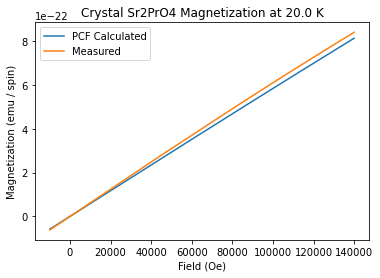

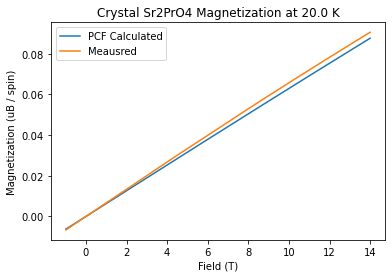

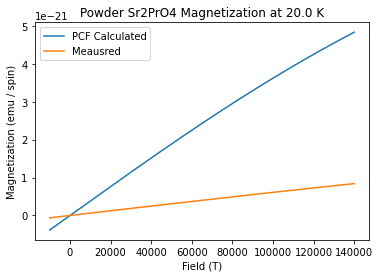

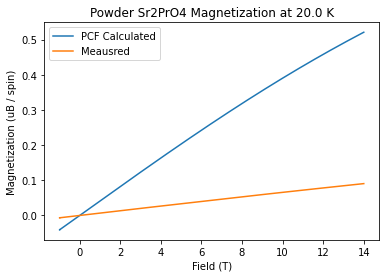

In [12]:
# Plot magnetization for:
# Calculated and measured: in (uB) and (emu)
#####################################################################################################################################################################
plt.figure()
plt.plot(H,-1*magCalcEmu, label = 'PCF Calculated')
plt.plot(H,M, label = 'Measured')
plt.xlabel('Field (Oe)')
plt.ylabel('Magnetization (emu / spin)')
plt.title('Crystal {} Magnetization at {} K'.format(comp,Temp))
plt.legend()

plt.figure()
plt.plot(HTes,-1*magCalcBohr, label = 'PCF Calculated')
plt.plot(HTes,MBohr, label = 'Meausred')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB / spin)')
plt.title('Crystal {} Magnetization at {} K'.format(comp,Temp))
plt.legend()

plt.figure()
plt.plot(H,-1*magCalcEmuPowder, label = 'PCF Calculated')
plt.plot(H,M, label = 'Meausred')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (emu / spin)')
plt.title('Powder {} Magnetization at {} K'.format(comp,Temp))
plt.legend()

plt.figure()
plt.plot(HTes,-1*magCalcBohrPowder, label = 'PCF Calculated')
plt.plot(HTes,MBohr, label = 'Meausred')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB / spin)')
plt.title('Powder {} Magnetization at {} K'.format(comp,Temp))
plt.legend()

plt.show()
#####################################################################################################################################################################